In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

%matplotlib inline

## Basic approach using Softmax regression

In [2]:
from tensorflow.examples.tutorials.mnist import input_data


mnist = input_data.read_data_sets("./MNIST_data", one_hot=True)

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
mnist.train.images[1]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [4]:
mnist.train.labels[1]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

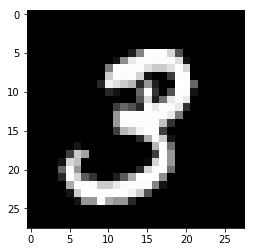

In [5]:
plt.imshow(mnist.train.images[1].reshape(28, 28), cmap='gist_gray')

In [6]:
x = tf.placeholder(tf.float32, shape=[None, 784])

In [7]:
W = tf.get_variable("W", shape=[784, 10], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable("b", shape=[10], initializer=tf.contrib.layers.xavier_initializer())

In [8]:
y = tf.matmul(x, W) + b

In [9]:
y_true = tf.placeholder(tf.float32, shape=[None, 10])

In [10]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(
        labels=y_true,
        logits=y
    )
)

In [11]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5)

In [12]:
train = optimizer.minimize(cross_entropy)

In [13]:
init = tf.global_variables_initializer()

In [14]:
with tf.Session() as sess:
    sess.run(init)
    
    for step in range(1000):
        batch_x, batch_y = mnist.train.next_batch(100)
        
        sess.run(train, feed_dict={
            x: batch_x,
            y_true: batch_y
        })
    
    correct_prediction = tf.equal(
        tf.argmax(y, axis=1), tf.argmax(y_true, axis=1)
    )

    accuracy = tf.reduce_mean(
        tf.cast(correct_prediction, tf.float32)
    )
    
    print(
        sess.run(accuracy, feed_dict={
            x: mnist.test.images,
            y_true: mnist.test.labels
        })
    )

0.9175


## CNN

In [15]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    
    return tf.Variable(init_random_dist)

In [16]:
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    
    return tf.Variable(init_bias_vals)

In [17]:
# conv2d

def conv2d(x, W):
    # x -> [batch, H, W, Channels]
    # W -> [filter H, filter W, Channels IN, Channels OUT]
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [18]:
def max_pool_2by2(x):
    # x -> [batch, H, W, Channels]
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [19]:
# Convulutional layer

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    
    return tf.nn.relu(conv2d(input_x, W) + b)

In [20]:
# normal (fully connected)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    
    return tf.matmul(input_layer, W) + b

In [21]:
# placeholders

x = tf.placeholder(tf.float32, shape=[None, 784])
y_true = tf.placeholder(tf.float32, shape=[None, 10])

In [22]:
x_image = tf.reshape(x, [-1, 28, 28, 1])

In [23]:
convo_1 = convolutional_layer(x_image, shape=[5, 5, 1, 32])
convo_1_pooling = max_pool_2by2(convo_1)

In [24]:
convo_2 = convolutional_layer(convo_1_pooling, shape=[5, 5, 32, 64])
convo_2_pooling = max_pool_2by2(convo_2)

In [25]:
convo_2_flat = tf.reshape(convo_2_pooling, [-1, 7 * 7 * 64])
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat, 1024))

In [26]:
# dropout
hold_prob = tf.placeholder(tf.float32)
full_one_dropout = tf.nn.dropout(full_layer_one, keep_prob=hold_prob)

In [27]:
y_pred = normal_full_layer(full_one_dropout, 10)

In [28]:
# loss function

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true, logits=y_pred)
)

In [29]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

In [30]:
init = tf.global_variables_initializer()

In [31]:
steps = 5000

with tf.Session() as sess:
    sess.run(init)
    
    for i in range(steps):
        batch_x, batch_y = mnist.train.next_batch(50)
        
        sess.run(train, feed_dict={
            x: batch_x,
            y_true: batch_y,
            hold_prob: 0.5
        })
        
        if i % 100 == 0:
            print(f"ON STEP: {i}")
            
            matches = tf.equal(
                tf.argmax(y_pred, 1), tf.argmax(y_true, 1)
            )
            
            acc = tf.reduce_mean(tf.cast(matches, tf.float32))
            
            print(
                "ACCURACY: {}".format(
                    sess.run(acc, feed_dict={
                        x: mnist.test.images,
                        y_true: mnist.test.labels,
                        hold_prob: 1.0
                    })
                )                
            )
            print('\n')

ON STEP: 0
ACCURACY: 0.1136000007390976


ON STEP: 100
ACCURACY: 0.9451000094413757


ON STEP: 200
ACCURACY: 0.9678999781608582


ON STEP: 300
ACCURACY: 0.9700999855995178


ON STEP: 400
ACCURACY: 0.9740999937057495


ON STEP: 500
ACCURACY: 0.9793000221252441


ON STEP: 600
ACCURACY: 0.9797000288963318


ON STEP: 700
ACCURACY: 0.9822999835014343


ON STEP: 800
ACCURACY: 0.982699990272522


ON STEP: 900
ACCURACY: 0.9811999797821045


ON STEP: 1000
ACCURACY: 0.9850999712944031


ON STEP: 1100
ACCURACY: 0.9843999743461609


ON STEP: 1200
ACCURACY: 0.9855999946594238


ON STEP: 1300
ACCURACY: 0.9854999780654907


ON STEP: 1400
ACCURACY: 0.9854000210762024


ON STEP: 1500
ACCURACY: 0.9839000105857849


ON STEP: 1600
ACCURACY: 0.9878000020980835


ON STEP: 1700
ACCURACY: 0.9842000007629395


ON STEP: 1800
ACCURACY: 0.9868999719619751


ON STEP: 1900
ACCURACY: 0.9876999855041504


ON STEP: 2000
ACCURACY: 0.9876999855041504


ON STEP: 2100
ACCURACY: 0.9878000020980835


ON STEP: 2200
ACCURACY: